In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns 
import statsmodels.formula.api as smf
from scipy.stats import probplot
from scipy.stats import kstest
%matplotlib inline

Load and prepare data

In [90]:
data = pd.read_csv('EyeGEx_retina_combined_genelevel_expectedcounts_byrid_nooutliers.counts.matrix.tsv',
                   sep='\t',
                   index_col=0)
annotation = pd.read_csv('EyeGEx_meta_combined_inferior_retina_summary_deidentified.txt',
                         sep=' ')
annotation.index = annotation['r_id'].values
good_samples = np.intersect1d(annotation.index.values, data.columns.values) #make sure to use only intersection 
data = data.loc[:,good_samples]
annotation = annotation.loc[good_samples,:]

In [63]:
data.head()

,100_2,101_3,102_2,103_3,104_2,105_2,106_4,107_4,109_1,110_3,...,91_2,92_3,93_2,94_4,95_4,96_3,97_2,98_3,99_1,9_1
ENSG00000000003,225.00,252.0,136.0,166.0,207.0,121.0,127.0,304.0,227.0,194.0,...,149.0,186.0,71.0,272.0,136.0,324.0,158.0,168.0,167.0,151.0
ENSG00000000005,0.00,0.0,1.0,4.0,0.0,0.0,0.0,0.0,4.0,0.0,...,0.0,3.0,1.0,1.0,1.0,1.0,2.0,1.0,0.0,0.0
ENSG00000000419,254.00,301.0,173.0,264.0,307.0,140.0,164.0,279.0,216.0,307.0,...,148.0,265.0,86.0,326.0,283.0,300.0,242.0,286.0,207.0,227.0
ENSG00000000457,422.99,510.0,272.0,301.0,417.0,116.0,198.0,278.0,243.0,451.0,...,163.0,227.0,96.0,418.0,338.0,277.0,342.0,343.0,140.0,325.0
ENSG00000000460,272.00,310.0,204.0,224.0,227.0,149.0,253.0,171.0,274.0,283.0,...,168.0,308.0,86.0,284.0,260.0,179.0,210.0,225.0,124.0,192.0


In [36]:
annotation.head()

,r_id,sample_id,os_od,age,sex,mgs_level,rin,postmortem_interval_hrs
100_2,100_2,100,OS,70.0,F,2.0,7.4,22.75
101_3,101_3,101,OS,94.0,M,3.0,7.8,19.48
102_2,102_2,102,OD,66.0,F,2.0,7.7,22.77
103_3,103_3,103,OS,93.0,F,3.0,6.7,9.82
104_2,104_2,104,OD,80.0,F,2.0,7.0,10.15


task 0.1 Let's look at our features from annotation, make pait plots using seaborn paiplot (excluding sample_id and os_od), using sex as a group. What can we tell about our data?

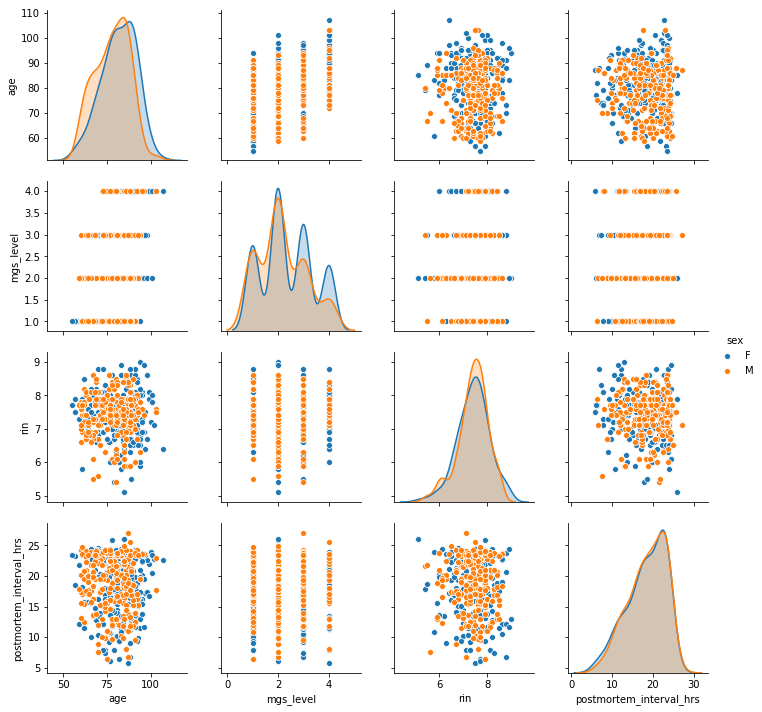

In [40]:
#solution
sns.pairplot(annotation.loc[:,['age','sex','mgs_level','rin','postmortem_interval_hrs']], hue='sex')
#mgs_level - discrete variable, others are continuous, distribution for male and female seems to be same 

task 0.2 Now it is time to understand our gene expression. How many genes with zero expression we have? Plot histogramm of log(mean) expression. Keep only genes with mean expression > 50. Plot histogram  of sd / mean genes. What can we say? Take only genes with sd/mean > 1

Genes with zero expression 12754 out of 58051
After filtering genes with zero expression: 11398 genes left


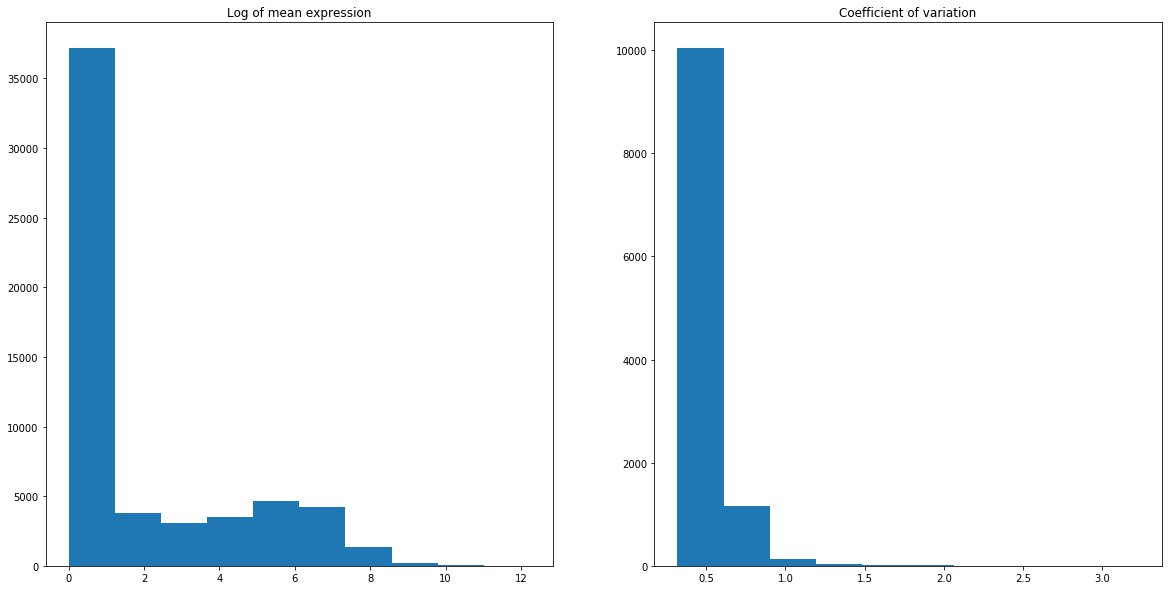

In [92]:
#solution
f, ax = plt.subplots(1,2, figsize = (20, 10))
mean_expr = data.mean(axis=1)
print('Genes with zero expression {} out of {}'.format(sum(mean_expr==0), mean_expr.shape[0]))
ax[0].hist(np.log(mean_expr+1));
ax[0].set_title('Log of mean expression')
data = data.loc[mean_expr>100, ]
print('After filtering genes with low expression: {} genes left'.format(data.shape[0]))
#recalculate stats
mean_expr = data.mean(axis=1)
sd_expr = np.sqrt(data.var(axis=1))
ax[1].hist(sd_expr/mean_expr);
ax[1].set_title('Coefficient of variation')
#we say that genes are  mostrly not variable at all and only few of them are variable
data = data.loc[((sd_expr/mean_expr) > 1).values, :]
print('After selecting genes by CV {} left'.format(data.shape[0]))

task 1. Compute correlation between genes using np.corrcoef. Make histogramm of genes correlation using seaborn clustermap with method ward and metric euclidian. What can we say about this heatmap?

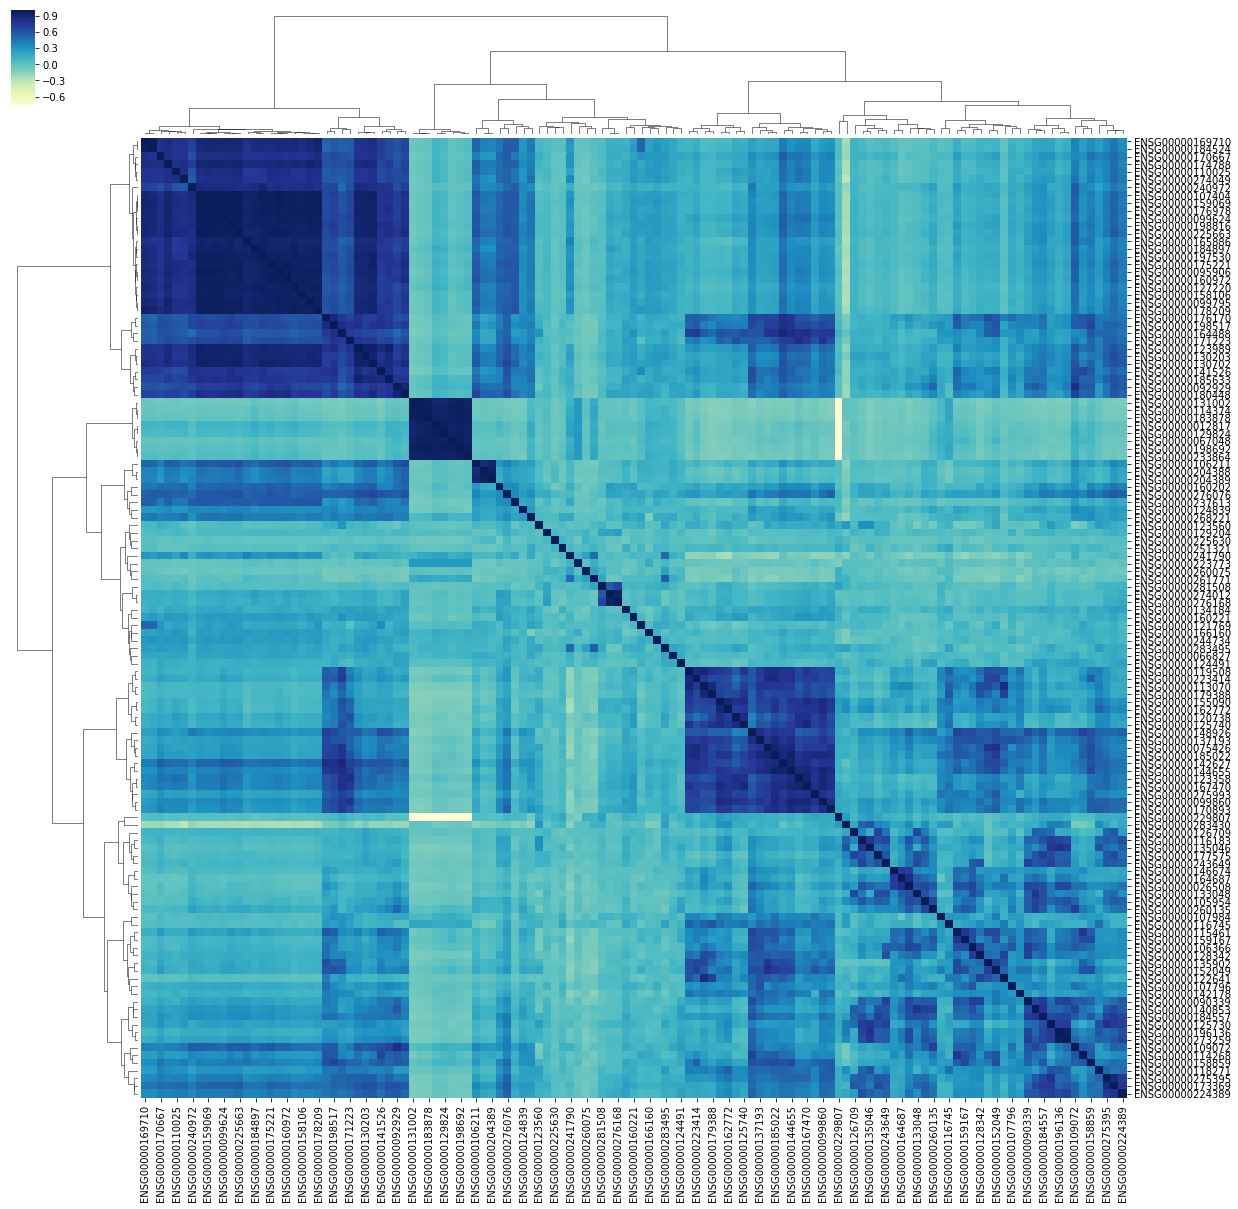

In [119]:
genes_corr = np.corrcoef(data.values)
genes_corr = pd.DataFrame(genes_corr, index=data.index.values, columns=data.index.values)
sns.clustermap(genes_corr, method='ward', 
               metric='euclidean', cmap="YlGnBu", 
               figsize=(20,20), yticklabels=True);
#we have block of correlated genes

extra task 1. Use hierarchical clustering to define higly correlated groups of genes and from each group keep only gene, mostly correlated with age

In [124]:
#no solution

warm up linear model task. Find how many genes are upregulated with age. By downregulated by age we will call genes with positive coefficient in a linear model (take Pval <0.05). For that use linregress from scipy.stats. How many genes do we detect? 

In [239]:
#solution
#Should we use pvalue correction for multiple testing?
gene_list = []
for gene in data.index.values:
    slope, intercept, r_value, p_value, std_err = linregress(x=annotation['age'].values, y = data.loc[gene,:].values)
    if p_value < 0.05 and slope > 0:
        print('gene {} R square {}'.format(gene, r_value**2))
        gene_list.append(gene)

gene ENSG00000026508 R square 0.0091852596614238
gene ENSG00000090339 R square 0.03610804897623566
gene ENSG00000099860 R square 0.0262035471868104
gene ENSG00000105954 R square 0.03683290657769766
gene ENSG00000116183 R square 0.07203568622804532
gene ENSG00000116745 R square 0.01076121135386072
gene ENSG00000118271 R square 0.03661112138875051
gene ENSG00000124839 R square 0.019381184598399003
gene ENSG00000125730 R square 0.09089457928113695
gene ENSG00000125740 R square 0.008692188056441265
gene ENSG00000126709 R square 0.012591124461424904
gene ENSG00000134184 R square 0.009842096800008042
gene ENSG00000135046 R square 0.09565466394316235
gene ENSG00000140853 R square 0.021915573700580487
gene ENSG00000148926 R square 0.03188945139858815
gene ENSG00000155090 R square 0.01747806848918293
gene ENSG00000162772 R square 0.020128581962867372
gene ENSG00000167470 R square 0.009489500960447206
gene ENSG00000170893 R square 0.009600593695019794
gene ENSG00000173369 R square 0.030498856001

linear model task. Now lets try the opposite thing. Let's try to predict gene expression using age, sex, mgs_level, and rin as outcome. For simplicity take only genes which were detected in the previous task. At least we will know that they should be related to gene expression level. Before that perform one hot encoding on os_od and sex. (optionally check if treating mgs_level as categorical gives any benefits). Here we will be using statsmodels with formulas, like in R, because R is good.   
1. Expression of which gene is explained the best by our factors? (Using R^2 adjusted)  
2. Which genes are sex-dependent?   
3. Which genes are age-dependent?

In [241]:
#first merge data and annotaton for simplicity 
prepared_data = annotation.merge(data.loc[gene_list, :].T, how='inner', left_index=True, right_index=True)
#encode sex and os_od + fix 0S to OS. 
prepared_data.loc[prepared_data['os_od']=='0S','os_od'] = 'OS'
prepared_data = prepared_data.merge(pd.get_dummies(prepared_data['sex'], prefix='sex_'), 
                                    left_index=True, right_index=True)
prepared_data = prepared_data.merge(pd.get_dummies(prepared_data['os_od'], prefix='os_od_'), 
                                    left_index=True, right_index=True)
#interesting, they are in fact redundant. we need n-1 for n factors, as an extra task - check if it affects results
prepared_data.drop(['sex__F','os_od__OS'],axis=1,inplace=True)

In [242]:
#source: https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
rsquared_list = []
for gene in gene_list:
    print(20*'=')
    lm_smf = smf.ols(formula='{} ~ age + mgs_level + rin + sex__M + os_od__OD'.format(gene), 
                     data=prepared_data.loc[prepared_data[gene]>0, :]).fit()
    rsquared = lm_smf.rsquared_adj
    pval_sex = lm_smf.pvalues['sex__M']
    coef_sex = lm_smf.params['sex__M']
    pval_age = lm_smf.pvalues['age']
    coef_age = lm_smf.params['age']
    print('Fitted linear model for {}; R^2 adjusted {}, age coeff {}, pval {}, sex coeff {}, pval {}'.format(gene,
                                                                                                            rsquared,
                                                                                                            coef_age,
                                                                                                            pval_age,
                                                                                                            coef_sex,
                                                                                                            pval_sex))
    if pval_age < 0.05:
        print('gene is age-dependent')
    if pval_sex < 0.05:
        print('gene is sex-dependent')
    rsquared_list.append(rsquared)
best_gene = gene_list[np.argmax(rsquared_list)]
best_rsquare = max(rsquared_list)
print('Best fitted gene {}, Rsquared {}'.format(best_gene, best_rsquare))

Fitted linear model for ENSG00000026508; R^2 adjusted 0.022639223224963922, age coeff 9.30902085000683, pval 0.1159318367239647, sex coeff -274.00012682906345, pval 0.009002628364644766
gene is sex-dependent
Fitted linear model for ENSG00000090339; R^2 adjusted 0.03738421569319239, age coeff 9.84806026232651, pval 0.00048792673917590025, sex coeff -46.96625112396295, pval 0.34361302222506107
gene is age-dependent
Fitted linear model for ENSG00000099860; R^2 adjusted 0.028331388706691385, age coeff 15.402894798105097, pval 0.009577797416255076, sex coeff -210.7236888271095, pval 0.04458334433016701
gene is age-dependent
gene is sex-dependent
Fitted linear model for ENSG00000105954; R^2 adjusted 0.04232302014484368, age coeff 63.77479918824777, pval 0.0011474477644863412, sex coeff -664.4312050954117, pval 0.05431270323499174
gene is age-dependent
Fitted linear model for ENSG00000116183; R^2 adjusted 0.06845599214875675, age coeff 13.874490439118285, pval 5.1923051713166426e-06, sex coef

/home/skolchen/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


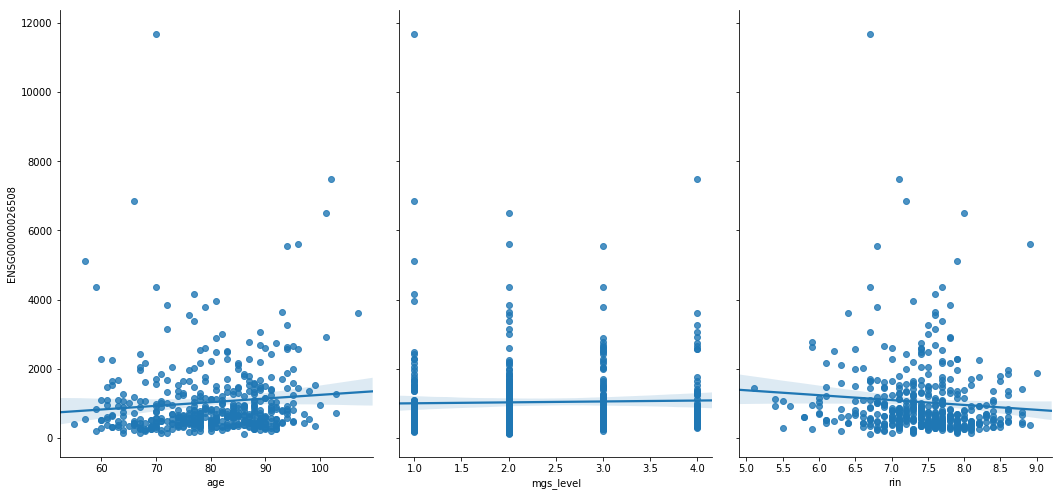

In [243]:
#for example, we can visualize our data using seaborn
sns.pairplot(prepared_data.loc[prepared_data[gene_list[0]]>0,:],
             x_vars=['age','mgs_level','rin'], y_vars=gene_list[0], size=7, aspect=0.7, kind='reg');

Now let's try some feature selection and interactions between variables. Make a new variable as an interaction between sex and os_od, ecnode it, and see if it increases the quality

In [193]:
prepared_data.head()

,r_id,sample_id,os_od,age,sex,mgs_level,rin,postmortem_interval_hrs,ENSG00000012817,ENSG00000067048,...,ENSG00000129824,ENSG00000131002,ENSG00000135902,ENSG00000183878,ENSG00000198692,ENSG00000223773,ENSG00000233864,ENSG00000244734,sex__M,os_od__OD
100_2,100_2,100,OS,70.0,F,2.0,7.4,22.75,0.0,0.0,...,0.00,0.0,47.0,0.0,0.0,16.0,0.0,48.0,0,0
101_3,101_3,101,OS,94.0,M,3.0,7.8,19.48,1781.0,2350.0,...,1958.99,1640.0,108.0,687.0,311.0,22.0,319.0,177.0,1,0
102_2,102_2,102,OD,66.0,F,2.0,7.7,22.77,0.0,0.0,...,0.00,0.0,248.0,0.0,0.0,10.0,0.0,56.0,0,1
103_3,103_3,103,OS,93.0,F,3.0,6.7,9.82,0.0,1.0,...,0.00,0.0,79.0,0.0,0.0,14.0,0.0,115.0,0,0
104_2,104_2,104,OD,80.0,F,2.0,7.0,10.15,0.0,0.0,...,0.00,0.0,78.0,0.0,0.0,18.0,0.0,188.0,0,1


In [ ]:
prepared_data['sex_osod'] = prepared_data['sex']+prepared_data['os_od']

In [246]:
prepared_data = prepared_data.merge(pd.get_dummies(prepared_data['sex_osod'], prefix='sex_osod_'), 
                                    left_index=True, right_index=True)
prepared_data.drop(['sex_osod__MOS'],axis=1,inplace=True)

In [247]:
#source: https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
rsquared_list = []
for gene in gene_list:
    print(20*'=')
    lm_smf = smf.ols(formula='{} ~ age + mgs_level + rin + sex__M + os_od__OD + sex_osod__FOD + sex_osod__FOS + sex_osod__MOD'.format(gene), data=prepared_data).fit()
    rsquared = lm_smf.rsquared_adj
    pval_sex_osod__MOD = lm_smf.pvalues['sex_osod__MOD']
    coef_sex_osod__MOD = lm_smf.params['sex_osod__MOD']
    pval_sex_osod__FOS = lm_smf.pvalues['sex_osod__FOS']
    coef_sex_osod__FOS = lm_smf.params['sex_osod__FOS']
    pval_sex_osod__FOD = lm_smf.pvalues['sex_osod__FOD']
    coef_sex_osod__FOD = lm_smf.params['sex_osod__FOD']
    print('Fitted linear model for {}; R^2 adjusted {}, sex_osod__MOD coeff {}, pval {}, sex_osod__FOS coeff {}, pval {} , sex_osod__FOD coeff {}, pval {}'.format(gene,
                                                                                                            rsquared,
                                                                                                            coef_sex_osod__MOD,
                                                                                                            pval_sex_osod__MOD,
                                                                                                            coef_sex_osod__FOS,
                                                                                                            pval_sex_osod__FOS,
                                                                                                            coef_sex_osod__FOD,
                                                                                                            pval_sex_osod__FOD,))

    rsquared_list.append(rsquared)
best_gene = gene_list[np.argmax(rsquared_list)]
best_rsquare = max(rsquared_list)
print('Best fitted gene {}, Rsquared {}'.format(best_gene, best_rsquare))
#So here quality didn't increase  - these features didn't bring any new information, even though they are kind of significant. 

Fitted linear model for ENSG00000026508; R^2 adjusted 0.022457345260174177, sex_osod__MOD coeff -202.13654063075137, pval 0.08681485587879129, sex_osod__FOS coeff 406.0630122444908, pval 0.06389203801265854 , sex_osod__FOD coeff 400.5703262537994, pval 0.008352552807930052
Fitted linear model for ENSG00000090339; R^2 adjusted 0.03524416261360708, sex_osod__MOD coeff 42.03253179579841, pval 0.45267068930873655, sex_osod__FOS coeff -21.94866010850688, pval 0.8326194300274818 , sex_osod__FOD coeff 11.120453674881803, pval 0.8769675682307015
Fitted linear model for ENSG00000099860; R^2 adjusted 0.03099181172231469, sex_osod__MOD coeff 113.66195190888759, pval 0.33514342929934027, sex_osod__FOS coeff 242.34479580563863, pval 0.2682885564395564 , sex_osod__FOD coeff 49.45416766313397, pval 0.7438100716434969
Fitted linear model for ENSG00000105954; R^2 adjusted 0.041760524783648556, sex_osod__MOD coeff -338.5076808815709, pval 0.3839502838479636, sex_osod__FOS coeff 344.30868514457893, pval 

Fitted linear model for ENSG00000260135; R^2 adjusted 0.010112997285767311, sex_osod__MOD coeff -15.18758685440941, pval 0.512726243672101, sex_osod__FOS coeff 59.94424474546779, pval 0.16426787252278546 , sex_osod__FOD coeff 54.04053425105995, pval 0.07006840321658851
Fitted linear model for ENSG00000273259; R^2 adjusted 0.05025166615027554, sex_osod__MOD coeff -34.7828310043856, pval 0.8711225680460959, sex_osod__FOS coeff -66.76761410736823, pval 0.8667516120396737 , sex_osod__FOD coeff 115.51210562879625, pval 0.6747426845970166
Fitted linear model for ENSG00000275395; R^2 adjusted 0.04779900613907362, sex_osod__MOD coeff 14.616532186644237, pval 0.5346957624807945, sex_osod__FOS coeff -76.19559693020092, pval 0.08165004976456797 , sex_osod__FOD coeff -45.38528781187607, pval 0.133583353486079
Fitted linear model for ENSG00000283430; R^2 adjusted 0.046352110986687234, sex_osod__MOD coeff -19.215706772028987, pval 0.4116215383115934, sex_osod__FOS coeff -3.7064608851485055, pval 0.9

Now lets look at residuals. Refit models back without using interaction term and check for each gene if residuals are normaly distributed. For that you may need lm_smf.resid to get residuals and lm_smf.predict() to get predicted value in the model. You will probablu want to visualize your residuals with sns.kdeplot and probplot from scipy. For narmality test use scipy.stats.kstest

In [248]:
#reference http://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/
for gene in gene_list:
    lm_smf = smf.ols(formula='{} ~ age + mgs_level + rin + sex__M + os_od__OD'.format(gene), data=prepared_data).fit()
    data_res = pd.concat([prepared_data, 
                          pd.Series(lm_smf.resid, name = 'resid', index=prepared_data.index), 
                          pd.Series(lm_smf.predict(), name = "predict", index=prepared_data.index)], axis = 1)    
    resid = data_res.resid
    norm_resid = (data_res.resid - np.mean(data_res.resid)) / np.std(data_res.resid)
    p_val = kstest(norm_resid, 'norm')[1]
    if p_val<0.05:
        print('gene {} residuals not normaly distrobuted'.format(gene))

gene ENSG00000026508 residuals not normaly distrobuted
gene ENSG00000090339 residuals not normaly distrobuted
gene ENSG00000099860 residuals not normaly distrobuted
gene ENSG00000105954 residuals not normaly distrobuted
gene ENSG00000116183 residuals not normaly distrobuted
gene ENSG00000116745 residuals not normaly distrobuted
gene ENSG00000118271 residuals not normaly distrobuted
gene ENSG00000124839 residuals not normaly distrobuted
gene ENSG00000125730 residuals not normaly distrobuted
gene ENSG00000125740 residuals not normaly distrobuted
gene ENSG00000126709 residuals not normaly distrobuted
gene ENSG00000134184 residuals not normaly distrobuted
gene ENSG00000135046 residuals not normaly distrobuted
gene ENSG00000140853 residuals not normaly distrobuted
gene ENSG00000148926 residuals not normaly distrobuted
gene ENSG00000155090 residuals not normaly distrobuted
gene ENSG00000162772 residuals not normaly distrobuted
gene ENSG00000167470 residuals not normaly distrobuted
gene ENSG0

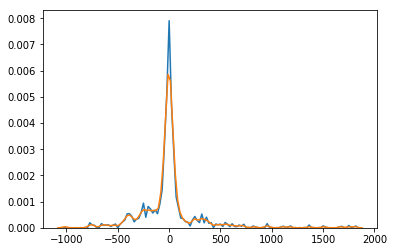

In [213]:
#example of visualization one
sns.kdeplot(np.array(data_res.resid), bw=10);
sns.distplot(np.array(data_res.resid), hist=False);

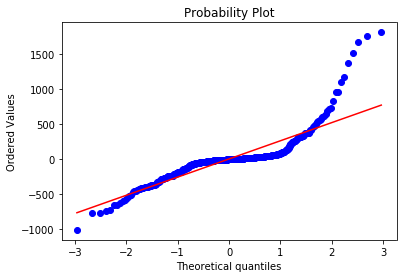

In [220]:
#example of visualization two
probplot(data_res.resid, dist="norm", plot=plt);

extra task. Go and find out about genes we have used in this task!

to do: heteroscedasticity, nonlinearity

linear regression adjustment. Lets fit model to log expression

In [249]:
#source: https://www.ritchieng.com/machine-learning-evaluate-linear-regression-model/
rsquared_list = []
for gene in gene_list:
    print(20*'=')
    prepared_data.loc[:,'log_{}'.format(gene)] = np.log(prepared_data[gene]+1)
    lm_smf = smf.ols(formula='log_{} ~ age + mgs_level + rin + sex__M + os_od__OD'.format(gene), 
                     data=prepared_data.loc[prepared_data[gene]>0, :]).fit()
    rsquared = lm_smf.rsquared_adj
    pval_sex = lm_smf.pvalues['sex__M']
    coef_sex = lm_smf.params['sex__M']
    pval_age = lm_smf.pvalues['age']
    coef_age = lm_smf.params['age']
    print('Fitted linear model for {}; R^2 adjusted {}, age coeff {}, pval {}, sex coeff {}, pval {}'.format(gene,
                                                                                                            rsquared,
                                                                                                            coef_age,
                                                                                                            pval_age,
                                                                                                            coef_sex,
                                                                                                            pval_sex))
    if pval_age < 0.05:
        print('gene is age-dependent')
    if pval_sex < 0.05:
        print('gene is sex-dependent')
    rsquared_list.append(rsquared)
best_gene = gene_list[np.argmax(rsquared_list)]
best_rsquare = max(rsquared_list)
print('Best fitted gene {}, Rsquared {}'.format(best_gene, best_rsquare))

Fitted linear model for ENSG00000026508; R^2 adjusted 0.03588175414506378, age coeff 0.010218931345603916, pval 0.012204314495018988, sex coeff -0.14674339818520887, pval 0.041464422866524284
gene is age-dependent
gene is sex-dependent
Fitted linear model for ENSG00000090339; R^2 adjusted 0.06600330328036852, age coeff 0.027066866333031868, pval 1.4067431604629899e-05, sex coeff -0.20466441597270665, pval 0.060897369549625976
gene is age-dependent
Fitted linear model for ENSG00000099860; R^2 adjusted 0.028601643395372522, age coeff 0.014424571360840166, pval 0.016264398594334768, sex coeff -0.19955150792637064, pval 0.05964841070381074
gene is age-dependent
Fitted linear model for ENSG00000105954; R^2 adjusted 0.06283741393930209, age coeff 0.021512322145474227, pval 0.00012802606857370867, sex coeff -0.23206047498521995, pval 0.01877167736561691
gene is age-dependent
gene is sex-dependent
Fitted linear model for ENSG00000116183; R^2 adjusted 0.06627682176601024, age coeff 0.0157935204

/home/skolchen/anaconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


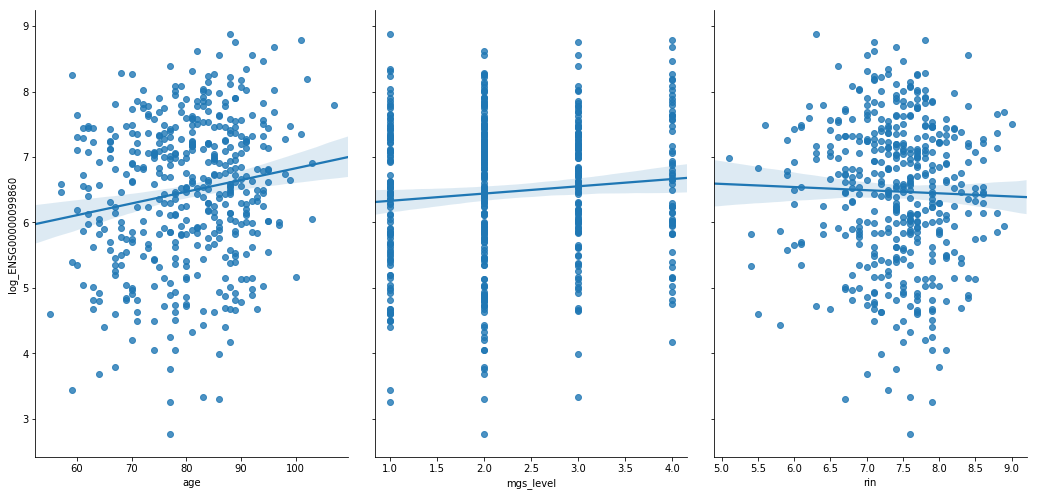

In [255]:
#for example, we can visualize our data using seaborn
sns.pairplot(prepared_data.loc[prepared_data[gene_list[0]]>0,:],
             x_vars=['age','mgs_level','rin'], y_vars='log_{}'.format(gene_list[2]), size=7, aspect=0.7, kind='reg');